# Sentiment Analysis of Yelp Reviews

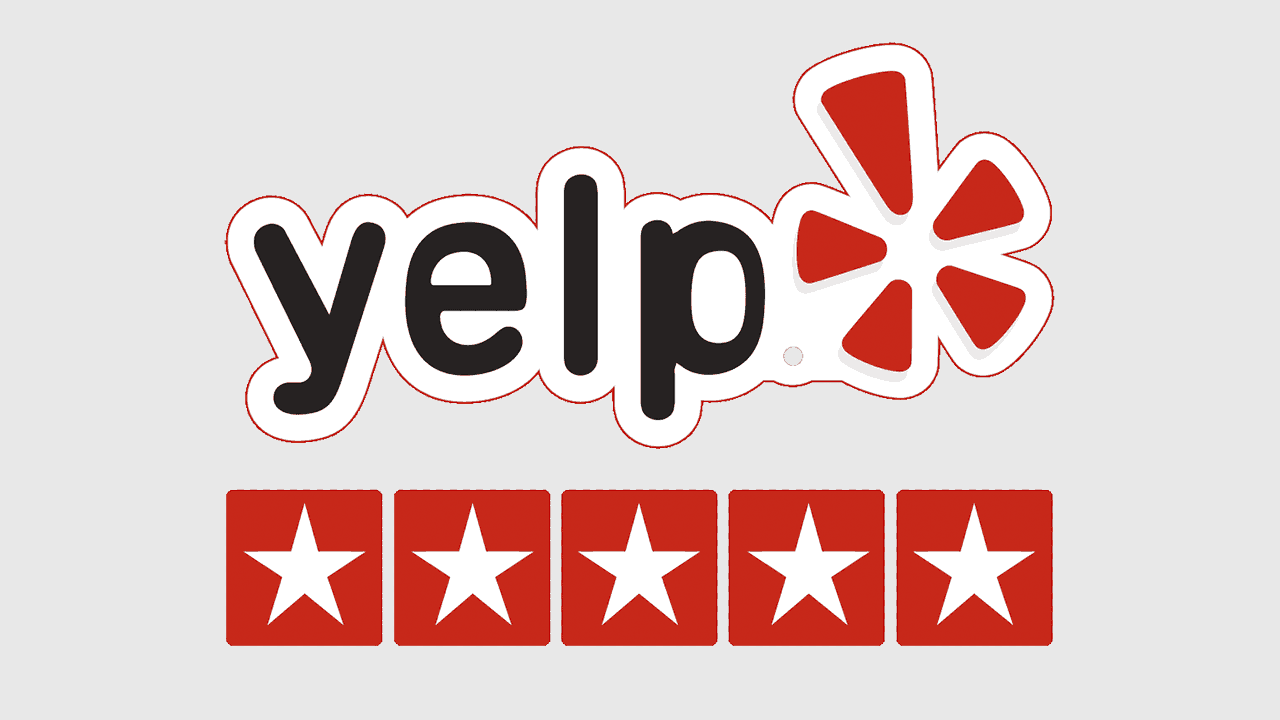

###Importing Libraries

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/classification-of-yelp-restaurant-reviews-using-sentiment-analysis/asset/sample_data.json

--2021-12-02 05:08:03--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/classification-of-yelp-restaurant-reviews-using-sentiment-analysis/asset/sample_data.json
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70142708 (67M) [application/json]
Saving to: ‘sample_data.json’

sample_data.json    100%[===================>]  66.89M  20.7MB/s    in 3.2s    

2021-12-02 05:08:07 (20.7 MB/s) - ‘sample_data.json’ saved [70142708/70142708]



###Exploratory Data Analysis

In [ ]:
yelp_revs = pd.read_json('sample_data.json')
yelp_revs.head()

,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,4686059,aFz1itIWIl7Qojxhpa0VoQ,SsUKdScC6NKcnFFio75wMA,H1ifIm6P1TgCjxM-TOlgTw,1,1,1,0,Ok so now i go to see a movie and homeboy hand...,2016-11-19 20:40:09,2016
1,6762380,s_ba4NB2G2QWS3izLkvl5Q,q5zFh3bhuLy6u7CzYlsa8Q,3r3RHfuLPgRSiRkp5udXSw,5,0,0,0,"It wasn't my choice to eat breakfast here, but...",2019-09-02 17:40:35,2019
2,491263,K1I5yuJICQpInOy-wCCo9A,UqqqBhqlAHiHfB_V3BNmvw,ljGzs5MhfnH1pKfJjFFRlQ,5,0,0,0,The staff is very friendly and I really like D...,2017-06-25 01:27:59,2017
3,6662859,NOwHErM1-u4d8Z6vSS7FwA,cmHaLdW8ssAXK2MKZ2idmw,xoJSkBTusOEt8PPvuw2qEQ,1,0,2,0,I usually have a great experience here but lef...,2017-02-05 20:22:26,2017
4,7361472,JjvOoHUs-OrPEnuUUanDsw,dTSwfFTTHPHwSe48qDkPXg,wTBid_bYRigHAl6vNHYeOQ,5,4,1,1,UPDATE:\nI have been contacted shortly after t...,2016-03-03 17:59:40,2016


In [ ]:
yelp_revs.shape
print(yelp_revs.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86354 entries, 0 to 86353
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        86354 non-null  int64         
 1   review_id    86354 non-null  object        
 2   user_id      86354 non-null  object        
 3   business_id  86354 non-null  object        
 4   stars        86354 non-null  int64         
 5   useful       86354 non-null  int64         
 6   funny        86354 non-null  int64         
 7   cool         86354 non-null  int64         
 8   text         86354 non-null  object        
 9   date         86354 non-null  datetime64[ns]
 10  year         86354 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 7.9+ MB
None


In [ ]:
yelp_revs.describe

<bound method NDFrame.describe of          index               review_id  ...                date  year
0      4686059  aFz1itIWIl7Qojxhpa0VoQ  ... 2016-11-19 20:40:09  2016
1      6762380  s_ba4NB2G2QWS3izLkvl5Q  ... 2019-09-02 17:40:35  2019
2       491263  K1I5yuJICQpInOy-wCCo9A  ... 2017-06-25 01:27:59  2017
3      6662859  NOwHErM1-u4d8Z6vSS7FwA  ... 2017-02-05 20:22:26  2017
4      7361472  JjvOoHUs-OrPEnuUUanDsw  ... 2016-03-03 17:59:40  2016
...        ...                     ...  ...                 ...   ...
86349  4601120  D467aq_VXL0SKJqp6SWPTw  ... 2012-02-17 18:02:35  2012
86350  4320363  KtMR2Eg9wa92doBKm-Kv7Q  ... 2016-01-17 16:34:22  2016
86351  4712218  csCAeaE-Ao-r_ezw-s3mww  ... 2016-05-03 23:31:14  2016
86352  7740980  VTDEeIqVQyKNLaq2Yf0tig  ... 2014-05-08 16:27:38  2014
86353  5606878  CGSSvIINJxvSBmrGZn5C-Q  ... 2011-04-18 20:52:21  2011

[86354 rows x 11 columns]>

In [ ]:
yelp_revs.columns

Index(['index', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date', 'year'],
      dtype='object')

In [ ]:
#Drop columns not to be used, they are not useful in the sentiment analysis procedure
revs = yelp_revs.drop(['index','date','year','business_id','review_id','user_id'], axis =1)

In [ ]:
revs['text length'] = yelp_revs['text'].apply(len)

In [ ]:
revs.head

<bound method NDFrame.head of        stars  ...  text length
0          1  ...          337
1          5  ...          308
2          5  ...          449
3          1  ...          403
4          5  ...         1551
...      ...  ...          ...
86349      4  ...          425
86350      5  ...          130
86351      5  ...          454
86352      4  ...         1613
86353      3  ...          291

[86354 rows x 6 columns]>

In [ ]:
revs.isnull().any().any() #Surprisingly there are no empty values

False

Text(0, 0.5, 'Count')

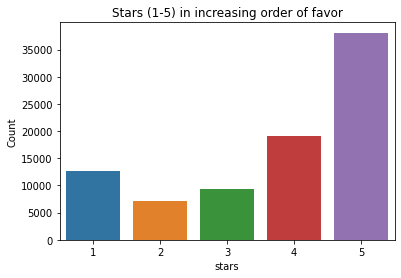

In [ ]:
#Distribution of Reviews

cplot = sns.countplot(x='stars', data=revs)
cplot.set_title('Stars (1-5) in increasing order of favor')
cplot.set_ylabel('Count')

Text(0.5, 1.0, 'Text Length Distribution')

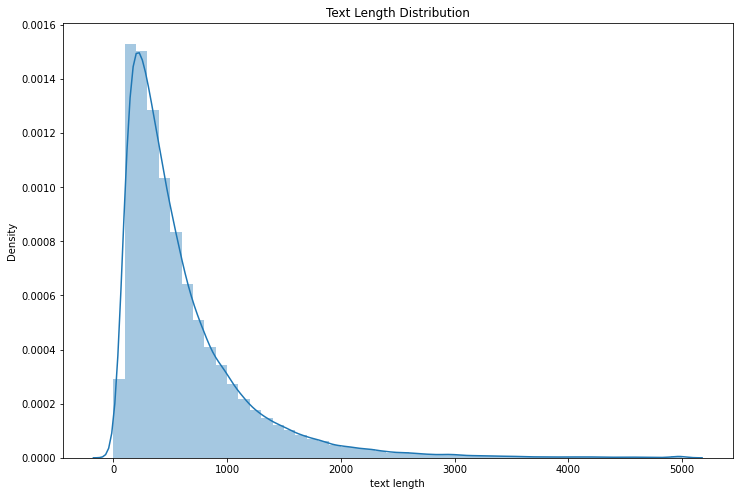

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.distplot(revs['text length'], kde=True, bins=50)
plt.title('Text Length Distribution')

###Data Cleaning

In [ ]:
# For sentiment analysis, only the text and the corresponding star ratign will be used
text = revs[['stars','text']]
text.head()

,stars,text
0,1,Ok so now i go to see a movie and homeboy hand...
1,5,"It wasn't my choice to eat breakfast here, but..."
2,5,The staff is very friendly and I really like D...
3,1,I usually have a great experience here but lef...
4,5,UPDATE:\nI have been contacted shortly after t...


In [ ]:
# Removal of stopwords, removal of all punctuation marks, and conversion of all text to lowercase. Only english reviews will be retained

cachedStopWords = stopwords.words("english")

def remove_punc_stopword(text):

    remove_punc = [word for word in text.lower() if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word not in cachedStopWords]

In [ ]:
cleaned_text = text.copy()
cleaned_text['text'] = text['text'].apply(remove_punc_stopword)

In [ ]:
cleaned_text.head()

,stars,text
0,1,"[ok, go, see, movie, homeboy, hands, sheet, wa..."
1,5,"[wasnt, choice, eat, breakfast, boss, paying, ..."
2,5,"[staff, friendly, really, like, dr, hap, denta..."
3,1,"[usually, great, experience, left, extremely, ..."
4,5,"[update, contacted, shortly, review, email, tc..."


###Make a Word Cloud with Most Frequently Occuring Negative Words

In [ ]:
def plot_Freq(data):
    FreqDist(np.concatenate(data.text.reset_index(drop=True))).plot(20, cumulative=False)

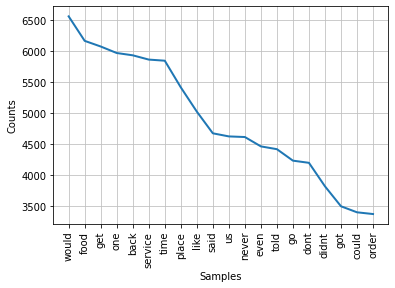

In [ ]:
plot_Freq(cleaned_text[cleaned_text['stars']==1]) #frequently used words in negative review

In [ ]:
#WordCloud
def reviewCloud(star):
    startext = ' '.join(text[text['stars']==star]['text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(startext))

    fig = plt.figure(
        figsize = (10, 7),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

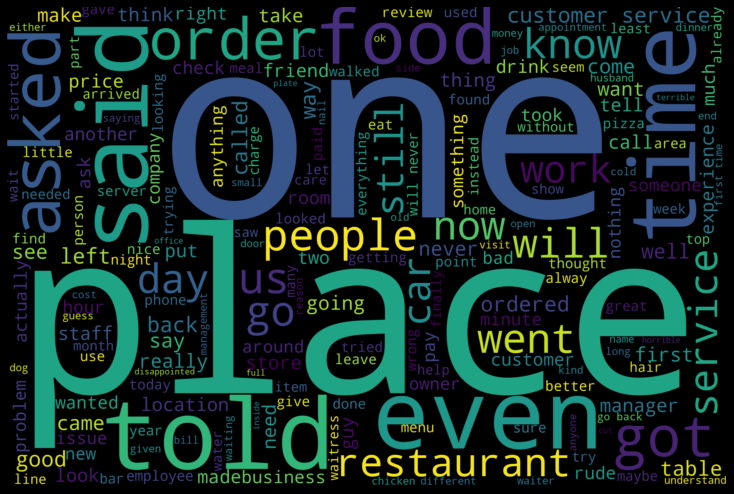

In [ ]:
reviewCloud(1)

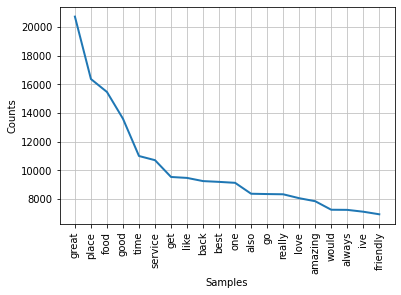

In [ ]:
plot_Freq(cleaned_text[cleaned_text['stars']==5]) #frequently used words in positive review

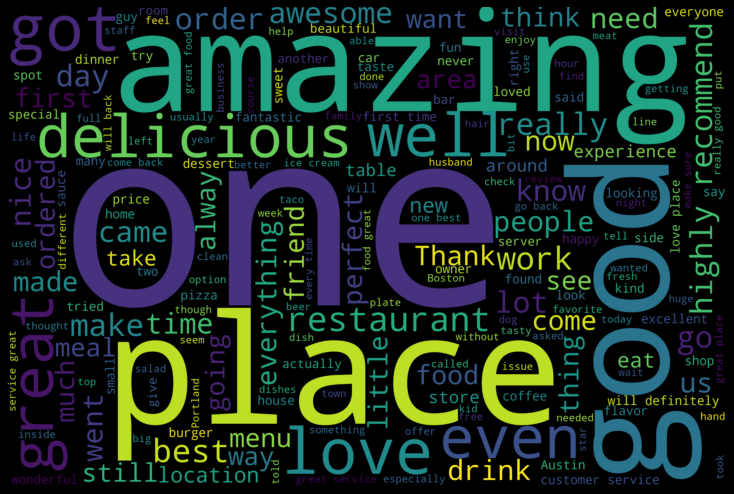

In [ ]:
reviewCloud(5) #Word cloud for positive reviews

###Modeling - The Model Will Classify Models into Positive or Negative

In [ ]:
select_stars = text[(text['stars']==1) | (text['stars']==5)] #Using only 1 and 5 star reviews

In [ ]:
x = select_stars['text']
y = select_stars['stars']

In [ ]:
# Tokenization using countvectorizer
count_vec = CountVectorizer().fit(x)
x = count_vec.transform(x)

In [ ]:
print("Shape of the sparse matrix: ", x.shape)

Shape of the sparse matrix:  (50802, 57396)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42) #Splitting into training and testing

In [ ]:
#Multinomial Naive Bayes Classifier

mnb = MultinomialNB()

mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)

print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[2239  282]
 [ 480 7160]]
Score: 92.5
Classification Report:               precision    recall  f1-score   support

           1       0.82      0.89      0.85      2521
           5       0.96      0.94      0.95      7640

    accuracy                           0.93     10161
   macro avg       0.89      0.91      0.90     10161
weighted avg       0.93      0.93      0.93     10161



In [ ]:
#Random Forest Classifier

RFC = RandomForestClassifier()

RFC.fit(x_train,y_train)
predrfc = RFC.predict(x_test)

print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrfc))
print("Score:",round(accuracy_score(y_test,predrfc)*100,2))
print("Classification Report:",classification_report(y_test,predrfc))

Confusion Matrix for Random Forest Classifier:
[[1709  812]
 [  80 7560]]
Score: 91.22
Classification Report:               precision    recall  f1-score   support

           1       0.96      0.68      0.79      2521
           5       0.90      0.99      0.94      7640

    accuracy                           0.91     10161
   macro avg       0.93      0.83      0.87     10161
weighted avg       0.92      0.91      0.91     10161



In [ ]:
#Support Vector Classifier

svc = svm.SVC(kernel = 'linear', C = 1, gamma = 'auto').fit(x_train,y_train)

predsvm = svc.predict(x_test)

print("Confusion Matrix for Support Vector Classifier:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Classifier:
[[2307  214]
 [ 186 7454]]
Score: 96.06
Classification Report:               precision    recall  f1-score   support

           1       0.93      0.92      0.92      2521
           5       0.97      0.98      0.97      7640

    accuracy                           0.96     10161
   macro avg       0.95      0.95      0.95     10161
weighted avg       0.96      0.96      0.96     10161



In [ ]:
#Support Vector Classifier returns the best performance metrics